# Proyek Klasifikasi Gambar: Fruits-360
- **Nama:** Rahelita Pasaribu
- **Email:** pasariburahelita@gmail.com
- **ID Dicoding:** rahelita113

## Import Semua Packages/Library yang Digunakan

In [10]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
import glob
import kagglehub
import splitfolders
print(tf.config.list_physical_devices('GPU'))
print(f"TensorFlow Version: {tf.__version__}")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow Version: 2.19.0


## Data Preparation

### Data Loading

In [11]:
# Download Dataset
print("1. Download Fruits-360 dataset dari Kaggle...")
dataset_path = kagglehub.dataset_download("moltean/fruits")
print("Dataset berhasil diunduh ke:", dataset_path)

# Mencari folder Training/Test
train_orig = glob.glob(os.path.join(dataset_path, "**/fruits-360/Training"), recursive=True)
test_orig  = glob.glob(os.path.join(dataset_path, "**/fruits-360/Test"), recursive=True)

if train_orig and test_orig:
    train_orig = train_orig[0]
    test_orig  = test_orig[0]
else:
    # fallback path
    train_orig = os.path.join(dataset_path, "fruits-360_100x100", "fruits-360", "Training")
    test_orig  = os.path.join(dataset_path, "fruits-360_100x100", "fruits-360", "Test")

print("Training folder asli:", train_orig)
print("Testing folder asli :", test_orig)

# Menggabungkan Training & Test ke folder sementara

merged_folder = os.path.join('/content/', "fruits_merged") # Changed path to /content/
if os.path.exists(merged_folder):
    shutil.rmtree(merged_folder)

os.makedirs(merged_folder)

# Menyalin semua subfolder dari Training
for cls in os.listdir(train_orig):
    src = os.path.join(train_orig, cls)
    dst = os.path.join(merged_folder, cls)
    shutil.copytree(src, dst)

# Menyalin semua subfolder dari Test
for cls in os.listdir(test_orig):
    src = os.path.join(test_orig, cls)
    dst = os.path.join(merged_folder, cls)
    if os.path.exists(dst):
        for f in os.listdir(src):
            shutil.copy(os.path.join(src, f), os.path.join(dst, f))
    else:
        shutil.copytree(src, dst)

print("Semua data Training & Test sudah digabung ke:", merged_folder)

1. Download Fruits-360 dataset dari Kaggle...
Using Colab cache for faster access to the 'fruits' dataset.
Dataset berhasil diunduh ke: /kaggle/input/fruits
Training folder asli: /kaggle/input/fruits/fruits-360_100x100/fruits-360/Training
Testing folder asli : /kaggle/input/fruits/fruits-360_100x100/fruits-360/Test
Semua data Training & Test sudah digabung ke: /content/fruits_merged


### Data Preprocessing

#### Split Dataset

In [12]:
# Split Manual 80/10/10
split_output = os.path.join('/content/', "fruits_split") # Changed path to /content/
if os.path.exists(split_output):
    shutil.rmtree(split_output)

splitfolders.ratio(
    merged_folder,
    output=split_output,
    seed=42,
    ratio=(.8, .1, .1)
)

train_dir = os.path.join(split_output, "train")
val_dir   = os.path.join(split_output, "val")
test_dir  = os.path.join(split_output, "test")

print("Folder Train :", train_dir)
print("Folder Val   :", val_dir)
print("Folder Test  :", test_dir)

# ImageDataGenerator
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 64
target_size = (100, 100)

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    horizontal_flip=True
)

train_generator = datagen.flow_from_directory(train_dir, target_size=(100,100), batch_size=64)
val_generator   = datagen.flow_from_directory(val_dir, target_size=(100,100), batch_size=64)
test_generator  = ImageDataGenerator(rescale=1./255).flow_from_directory(test_dir, target_size=(100,100))

num_train = train_generator.samples
num_val   = val_generator.samples
num_test  = test_generator.samples
num_classes = len(train_generator.class_indices)
class_names = list(train_generator.class_indices.keys())

print("\n--- Informasi Dataset ---")
print(f"Jumlah Data Train : {num_train}")
print(f"Jumlah Data Val   : {num_val}")
print(f"Jumlah Data Test  : {num_test}")
print(f"Total Dataset     : {num_train + num_val + num_test}")
print(f"Jumlah Kelas      : {num_classes}")
print(f"Contoh Nama Kelas : {class_names[:10]}")


Copying files: 159015 files [00:18, 8370.07 files/s]


Folder Train : /content/fruits_split/train
Folder Val   : /content/fruits_split/val
Folder Test  : /content/fruits_split/test
Found 127100 images belonging to 227 classes.
Found 15808 images belonging to 227 classes.
Found 16107 images belonging to 227 classes.

--- Informasi Dataset ---
Jumlah Data Train : 127100
Jumlah Data Val   : 15808
Jumlah Data Test  : 16107
Total Dataset     : 159015
Jumlah Kelas      : 227
Contoh Nama Kelas : ['Apple 10', 'Apple 11', 'Apple 12', 'Apple 13', 'Apple 14', 'Apple 17', 'Apple 18', 'Apple 19', 'Apple 5', 'Apple 6']


## Modelling

In [19]:
num_classes = len(train_generator.class_indices)
print(f"Jumlah kelas yang akan diprediksi: {num_classes}")

# Arsitektur CNN
model = Sequential([
    # Blok 1
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(100, 100, 3)),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    # Blok 2
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.3),

    # Blok 3
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.4),

    # Fully connected layers
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(num_classes, activation='softmax')
])

# Kompilasi model
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
    metrics=['accuracy']
)

# Ringkasan model
model.summary()

Jumlah kelas yang akan diprediksi: 227


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 100, 100, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 100, 100, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 100, 100, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 100, 100, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 50, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 50, 50, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 50, 50, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 50, 50, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 25, 25, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 25, 25, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 25, 25, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 25, 25, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     9,437,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 9,844,995 (37.56 MB)

 Trainable params: 9,843,075 (37.55 MB)

 Non-trainable params: 1,920 (7.50 KB)

## Evaluasi dan Visualisasi

Mulai Training...
Epoch 1/15
1986/1986 ━━━━━━━━━━━━━━━━━━━━ 440s 221ms/step - accuracy: 0.9732 - loss: 0.0949 - val_accuracy: 0.8852 - val_loss: 0.3959
Epoch 2/15
1986/1986 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.9818 - loss: 0.0596
TARGET TERCAPAI di Epoch 2! Akurasi Val > 96%
1986/1986 ━━━━━━━━━━━━━━━━━━━━ 442s 223ms/step - accuracy: 0.9818 - loss: 0.0596 - val_accuracy: 0.9886 - val_loss: 0.0374

Evaluasi Hasil Akhir...
1243/1243 ━━━━━━━━━━━━━━━━━━━━ 40s 32ms/step - accuracy: 0.9850 - loss: 0.0889

 Test Accuracy : 98.27%
   Test Loss     : 0.0863
Visualisasi Akurasi dan Loss


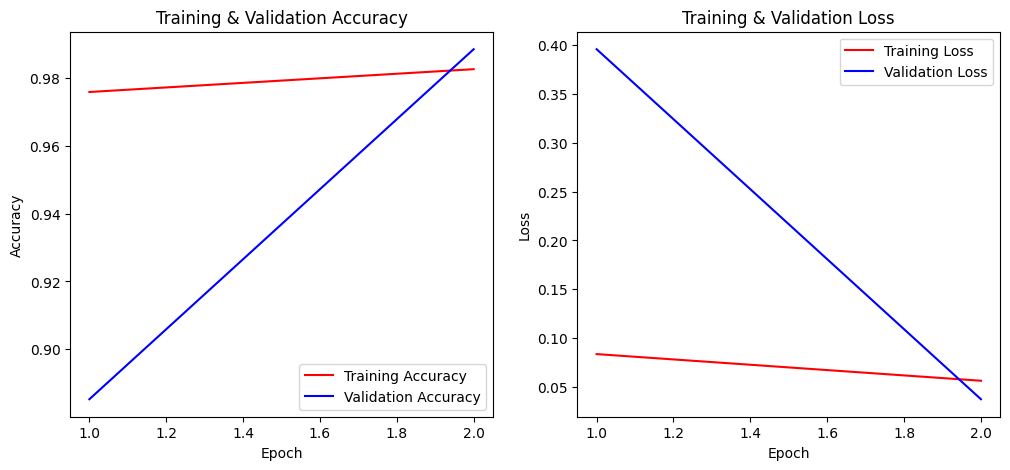

In [21]:
print("Mulai Training...")

# Callback
class MyHighAccuracyCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('val_accuracy') and logs.get('val_accuracy') > 0.96:
            print(f"\nTARGET TERCAPAI di Epoch {epoch+1}! Akurasi Val > 96%")
            self.model.stop_training = True

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True)

history = model.fit(
    train_generator,
    epochs=15,
    validation_data=val_generator,
    verbose=1,
    callbacks=[MyHighAccuracyCallback(), early_stop, checkpoint]
)

print("\nEvaluasi Hasil Akhir...")
test_loss, test_acc = model.evaluate(test_generator, verbose=1)
print(f"\n Test Accuracy : {test_acc * 100:.2f}%")
print(f"   Test Loss     : {test_loss:.4f}")

print("Visualisasi Akurasi dan Loss")

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))

# Plot akurasi
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'r-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b-', label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'r-', label='Training Loss')
plt.plot(epochs, val_loss, 'b-', label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Konversi Model

In [22]:
!pip install tensorflowjs
!tensorflowjs_converter --input_format=tf_saved_model saved_model/ tfjs_model/


2025-11-30 14:00:46.687586: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764511246.707786   19985 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764511246.713983   19985 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1764511246.731682   19985 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1764511246.731708   19985 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1764511246.731713   19985 computation_placer.cc:177] computation placer alr

In [23]:
import os
import tensorflow as tf
import shutil

# Hapus folder lama kalau sudah ada
if os.path.exists('saved_model'):
    shutil.rmtree('saved_model')

# Load the trained model from the saved checkpoint
# This ensures 'model' is defined even if the kernel was restarted.
model = tf.keras.models.load_model('best_model.keras')

# Simpan model dalam format SavedModel (default TensorFlow)
export_dir = 'saved_model'
model.export(export_dir)
print("Berhasil menyimpan model dalam format SavedModel")

# Konversi ke format TensorFlow Lite (.tflite)
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

print("Berhasil membuat model.tflite (TF-Lite)")

# Konversi ke format TensorFlow.js (TFJS)
!pip install tensorflowjs --quiet

!tensorflowjs_converter \
    --input_format=tf_saved_model \
    saved_model/ \
    tfjs_model/

print("Berhasil membuat model TFJS (TensorFlow.js)")

Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 227), dtype=tf.float32, name=None)
Captures:
  140435014218000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140435014214544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140435014219920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140435014217232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140435014219344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140435014216272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140435014218576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140435014218960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140435014215504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140435014220496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140435014220304:

## Inference (Optional)

--- PREDIKSI CONTOH GAMBAR DARI TEST SET ---
Found 39768 images belonging to 227 classes.


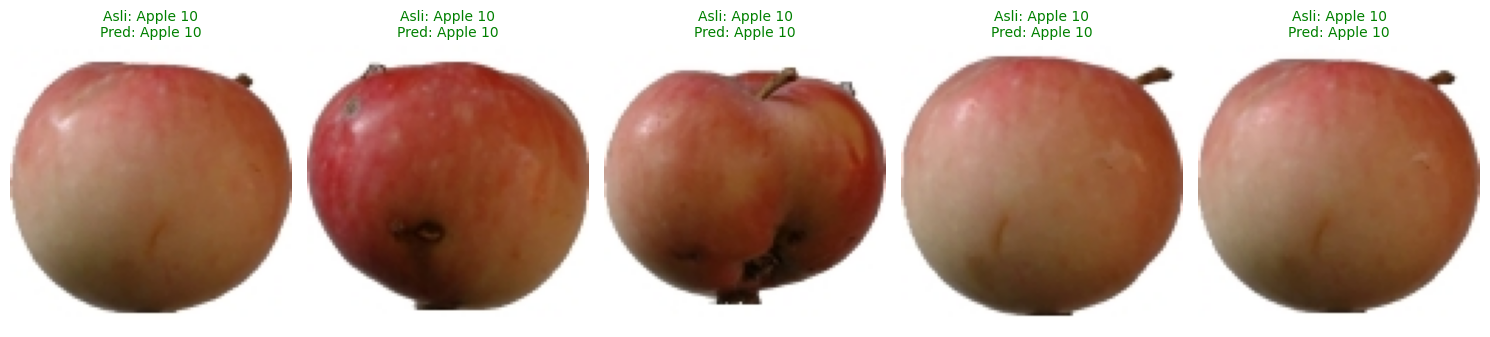

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

print("--- PREDIKSI CONTOH GAMBAR DARI TEST SET ---")

# Re-initialize test_generator for independent execution
test_dir  = "/kaggle/input/fruits/fruits-360_100x100/fruits-360/Test"
test_datagen = ImageDataGenerator(rescale=1./255)
batch_size = 32
target_size = (100, 100)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Load the model if it's not already defined (e.g., after kernel restart)
if 'model' not in locals():
    model = tf.keras.models.load_model('best_model.keras')

# Ambil nama kelas dari generator
class_names = list(test_generator.class_indices.keys())

# Ambil beberapa sampel acak dari test set
num_samples = 5
x_batch, y_batch = next(test_generator)

indices = np.random.choice(range(len(x_batch)), num_samples, replace=False)

plt.figure(figsize=(15, 6))

for i, idx in enumerate(indices):
    img = x_batch[idx]
    true_label = class_names[np.argmax(y_batch[idx])]

    # Prediksi
    pred = model.predict(np.expand_dims(img, axis=0), verbose=0)
    pred_label = class_names[np.argmax(pred)]

    # Plot gambar + hasil prediksi
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Asli: {true_label}\nPred: {pred_label}",
              color=("green" if true_label == pred_label else "red"),
              fontsize=10)

plt.tight_layout()
plt.show()

In [25]:
import os
import shutil
import tensorflow as tf
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

print("\nPROSES PEMBUATAN FILE SUBMISSION...")

# Simpan Model dalam 3 Format

export_dir = 'saved_model'
if os.path.exists(export_dir):
    shutil.rmtree(export_dir)

# Simpan model dalam format SavedModel
# Load the model if it's not already defined (e.g., after kernel restart)
if 'model' not in locals():
    model = tf.keras.models.load_model('best_model.keras')
model.export(export_dir)
print("Model disimpan dalam format SavedModel")

# Konversi ke format TF-Lite
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)
print("Model dikonversi ke TF-Lite (.tflite)")

# Konversi ke format TensorFlow.js
!pip install tensorflowjs --quiet
!tensorflowjs_converter --input_format=tf_saved_model saved_model/ tfjs_model/
print("Model dikonversi ke TensorFlow.js (TFJS)")

# Siapkan File Pendukung Submission

# Buat file requirements.txt
with open('requirements.txt', 'w') as f:
    f.write("tensorflow\nnumpy\nmatplotlib\ntensorflowjs\n")

# Buat direktori submission
base_dir = 'submission'
if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

os.makedirs(os.path.join(base_dir, 'tfjs_model'))
os.makedirs(os.path.join(base_dir, 'tflite'))
os.makedirs(os.path.join(base_dir, 'saved_model'))

# --- Salin file TFJS ---
src_tfjs = 'tfjs_model'
dst_tfjs = os.path.join(base_dir, 'tfjs_model')
if os.path.exists(src_tfjs):
    for item in os.listdir(src_tfjs):
        shutil.copy2(os.path.join(src_tfjs, item), os.path.join(dst_tfjs, item))

# --- Salin file TF-Lite ---
shutil.copy2('model.tflite', os.path.join(base_dir, 'tflite', 'model.tflite'))

# Simpan nama kelas dari dataset Fruits-360
# Re-initialize train_generator for independent execution if needed
if 'train_generator' not in locals():
    train_dir = "/kaggle/input/fruits/fruits-360_100x100/fruits-360/Training"
    train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.1)
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(100, 100),
        batch_size=32,
        class_mode='categorical',
        subset='training',
        shuffle=True
    )
class_names = list(train_generator.class_indices.keys())
with open(os.path.join(base_dir, 'tflite', 'label.txt'), 'w') as f:
    f.write('\n'.join(class_names))

# --- Salin folder SavedModel ---
src_saved = 'saved_model'
dst_saved = os.path.join(base_dir, 'saved_model')
for item in os.listdir(src_saved):
    s = os.path.join(src_saved, item)
    d = os.path.join(dst_saved, item)
    if os.path.isdir(s):
        shutil.copytree(s, d)
    else:
        shutil.copy2(s, d)

# --- Salin file tambahan ---
shutil.copy2('requirements.txt', os.path.join(base_dir, 'requirements.txt'))
with open(os.path.join(base_dir, 'README.md'), 'w') as f:
    f.write("# Submission Fruits-360\nModel CNN dengan Akurasi > 95% pada Data Validasi.")

# Buat File ZIP & Salin ke Drive

shutil.make_archive('submission_final', 'zip', base_dir)
target_drive = '/content/drive/MyDrive/SUBMISSION_Fruits360_KlasifikasiGambar.zip'
shutil.copy('submission_final.zip', target_drive)

print("\nSubmission berhasil dibuat!")
print(f"Lokasi file ZIP di Google Drive: {target_drive}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

PROSES PEMBUATAN FILE SUBMISSION...
Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 227), dtype=tf.float32, name=None)
Captures:
  140435014218000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140435014214544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140435014219920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140435014217232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140435014219344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140435014216272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140435014218576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140435014218960: TensorSpec(shape=(), dtype=tf.resource, nam